In [1]:
%run ./Definitions.ipynb

2019-12-24 16:41:10.119810
thunder  Tue Dec 24 16:41:10 2019
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Tue Dec 24 16:41:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

## Define Model and Metrics

In [13]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
     # Add the vgg convolutional base model
    model.add(mobile_conv)

    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [14]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [15]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [20]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 198910 validated image filenames.
Found 33943 validated image filenames.


In [21]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.0001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [22]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_F1', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

In [23]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 23s 464ms/step - loss: 0.6823 - Accuracy: 0.6125 - Precision: 0.5963 - Recall: 0.5705 - F1: 0.5739 - AUC: 0.6525 - val_loss: 1.6034 - val_Accuracy: 0.0344 - val_Precision: 0.0162 - val_Recall: 0.4000 - val_F1: 0.0311 - val_AUC: 0.7952
Epoch 2/200
50/50 [==============================] - 22s 436ms/step - loss: 0.6683 - Accuracy: 0.6137 - Precision: 0.6174 - Recall: 0.6658 - F1: 0.6335 - AUC: 0.6601 - val_loss: 1.5307 - val_Accuracy: 0.0375 - val_Precision: 0.0190 - val_Recall: 0.5000 - val_F1: 0.0364 - val_AUC: 0.5151
Epoch 3/200
50/50 [==============================] - 23s 457ms/step - loss: 0.6779 - Accuracy: 0.6106 - Precision: 0.6159 - Recall: 0.5658 - F1: 0.5831 - AUC: 0.6526 - val_loss: 0.7191 - val_Accuracy: 0.5594 - val_Precision: 0.0144 - val_Recall: 0.2000 - val_F1: 0.0268 - val_AUC: 0.5186
Epoch 4/200
50/50 [==============================] - 23s 467ms/step - loss: 0.6467 - Accuracy: 0.6338 - Precision: 0.6302 - Recall: 0.63

50/50 [==============================] - 24s 476ms/step - loss: 0.5514 - Accuracy: 0.7169 - Precision: 0.7177 - Recall: 0.7340 - F1: 0.7173 - AUC: 0.7936 - val_loss: 0.7699 - val_Accuracy: 0.4531 - val_Precision: 0.0289 - val_Recall: 0.4500 - val_F1: 0.0540 - val_AUC: 0.5803

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 30/200
50/50 [==============================] - 24s 482ms/step - loss: 0.5342 - Accuracy: 0.7369 - Precision: 0.7234 - Recall: 0.7634 - F1: 0.7377 - AUC: 0.8099 - val_loss: 0.7407 - val_Accuracy: 0.4500 - val_Precision: 0.0245 - val_Recall: 0.3500 - val_F1: 0.0456 - val_AUC: 0.5199
Epoch 31/200
50/50 [==============================] - 24s 484ms/step - loss: 0.5099 - Accuracy: 0.7531 - Precision: 0.7456 - Recall: 0.7842 - F1: 0.7600 - AUC: 0.8319 - val_loss: 0.8140 - val_Accuracy: 0.5000 - val_Precision: 0.0310 - val_Recall: 0.5000 - val_F1: 0.0583 - val_AUC: 0.7790
Epoch 32/200
50/50 [==============================] - 24s 471ms/s

Epoch 57/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5402 - Accuracy: 0.7381 - Precision: 0.7331 - Recall: 0.7693 - F1: 0.7443 - AUC: 0.8036 - val_loss: 0.6075 - val_Accuracy: 0.5969 - val_Precision: 0.0559 - val_Recall: 0.4167 - val_F1: 0.0977 - val_AUC: 0.6595
Epoch 58/200
50/50 [==============================] - 24s 473ms/step - loss: 0.5444 - Accuracy: 0.7306 - Precision: 0.7259 - Recall: 0.7601 - F1: 0.7352 - AUC: 0.7995 - val_loss: 0.6538 - val_Accuracy: 0.5562 - val_Precision: 0.0341 - val_Recall: 0.3500 - val_F1: 0.0612 - val_AUC: 0.5738
Epoch 59/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5121 - Accuracy: 0.7600 - Precision: 0.7530 - Recall: 0.7788 - F1: 0.7572 - AUC: 0.8342 - val_loss: 0.8172 - val_Accuracy: 0.5250 - val_Precision: 0.0258 - val_Recall: 0.3000 - val_F1: 0.0471 - val_AUC: 0.4630
Epoch 60/200
50/50 [==============================] - 24s 475ms/step - loss: 0.5313 - Accuracy: 0.7262 - Precision: 0.7306 - Recall: 

50/50 [==============================] - 24s 474ms/step - loss: 0.5230 - Accuracy: 0.7525 - Precision: 0.7479 - Recall: 0.7907 - F1: 0.7602 - AUC: 0.8246 - val_loss: 0.7776 - val_Accuracy: 0.5594 - val_Precision: 0.0349 - val_Recall: 0.4000 - val_F1: 0.0638 - val_AUC: 0.5028
Epoch 114/200
50/50 [==============================] - 24s 475ms/step - loss: 0.5144 - Accuracy: 0.7581 - Precision: 0.7606 - Recall: 0.7894 - F1: 0.7649 - AUC: 0.8312 - val_loss: 0.6570 - val_Accuracy: 0.6156 - val_Precision: 0.0183 - val_Recall: 0.2000 - val_F1: 0.0333 - val_AUC: 0.4430
Epoch 115/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5253 - Accuracy: 0.7400 - Precision: 0.7386 - Recall: 0.7726 - F1: 0.7480 - AUC: 0.8179 - val_loss: 0.7073 - val_Accuracy: 0.5625 - val_Precision: 0.0256 - val_Recall: 0.2500 - val_F1: 0.0458 - val_AUC: 0.6392
Epoch 116/200
50/50 [==============================] - 24s 470ms/step - loss: 0.5138 - Accuracy: 0.7538 - Precision: 0.7412 - Recall: 0.7909 - F

50/50 [==============================] - 24s 475ms/step - loss: 0.5221 - Accuracy: 0.7406 - Precision: 0.7267 - Recall: 0.7807 - F1: 0.7434 - AUC: 0.8218 - val_loss: 0.8369 - val_Accuracy: 0.5750 - val_Precision: 0.0231 - val_Recall: 0.2000 - val_F1: 0.0410 - val_AUC: 0.4795
Epoch 170/200
50/50 [==============================] - 24s 475ms/step - loss: 0.5169 - Accuracy: 0.7494 - Precision: 0.7552 - Recall: 0.7676 - F1: 0.7542 - AUC: 0.8302 - val_loss: 0.6713 - val_Accuracy: 0.6062 - val_Precision: 0.0439 - val_Recall: 0.4500 - val_F1: 0.0796 - val_AUC: 0.8237
Epoch 171/200
50/50 [==============================] - 24s 475ms/step - loss: 0.5222 - Accuracy: 0.7406 - Precision: 0.7495 - Recall: 0.7572 - F1: 0.7448 - AUC: 0.8209 - val_loss: 0.6103 - val_Accuracy: 0.5875 - val_Precision: 0.0304 - val_Recall: 0.2167 - val_F1: 0.0515 - val_AUC: 0.5404
Epoch 172/200
50/50 [==============================] - 24s 474ms/step - loss: 0.5207 - Accuracy: 0.7400 - Precision: 0.7551 - Recall: 0.7498 - F

In [24]:
print("Time taken:",end-start)

Time taken: 4719.648192882538


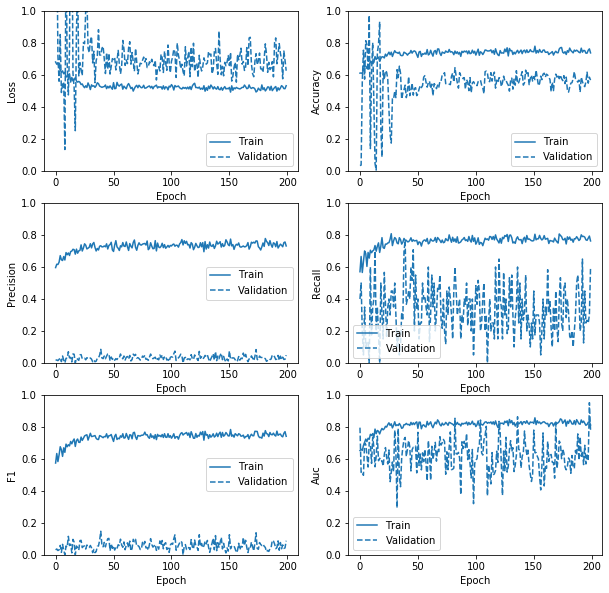

In [25]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [26]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 14s 140ms/step


In [27]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 0.777 :   0.571
Accuracy : 0.562 :   0.553
Precision : 0.538 :   0.028
Recall : 0.891 :   0.275
F1 : 0.665 :   0.050
AUC : 0.637 :   0.596


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [28]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(2820.73157453537, 214.1617796421051)

In [29]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [30]:
np.save(funduspath_CR + str(n_epochs) + 'ep_78_pred_tr.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_78_pred_vl.npy', pred_vl)

### Precision-Recall Curve

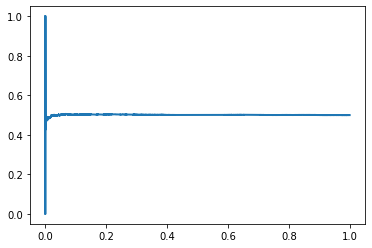

In [46]:
precision, recall, thresholds = precision_recall_curve(train_labels, pred_tr)
plt.plot(recall,precision, label="Precision-recall curve", linewidth=2)

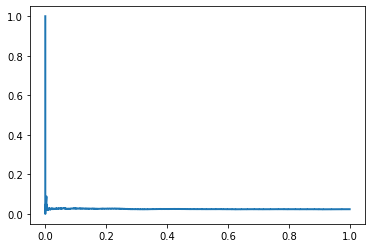

In [49]:
precision, recall, thresholds = precision_recall_curve(val_labels, pred_vl)
plt.plot(recall,precision, label="Precision-recall curve", linewidth=2)

### ROC Curve

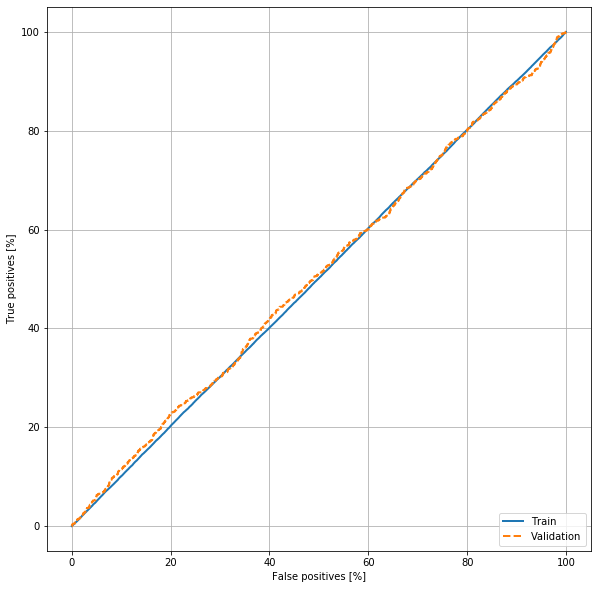

In [50]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 16458 
FP: 82997 
FN: 16229 
TP: 83226
Healthy Patients - correctly identified (True Negatives):  16458 0.1654818762254286
Healthy Patients - predicted to have glaucoma (False Positives):  82997 0.8345181237745715
Glaucoma Patients - predicted healthy (False Negatives):  16229 0.16317932733397014
Glaucoma Patients - correctly identified (True Positives):  83226 0.8368206726660299

Total Glaucoma patients:  99455 1.0
Total Healthy patients:  99455 1.0


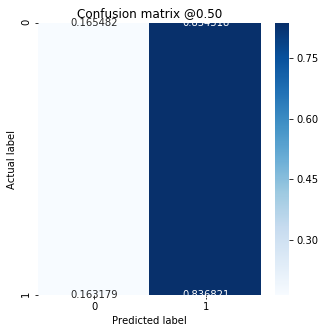

In [51]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 31044 
FP: 2090 
FN: 767 
TP: 42
Healthy Patients - correctly identified (True Negatives):  24597 0.7423492485060663
Healthy Patients - predicted to have glaucoma (False Positives):  8537 0.25765075149393374
Glaucoma Patients - predicted healthy (False Negatives):  610 0.754017305315204
Glaucoma Patients - correctly identified (True Positives):  199 0.24598269468479605

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


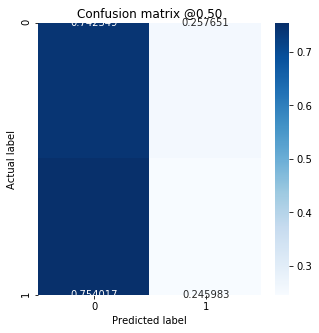

In [26]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [1]:
# # history = imb_history
# tag_value = "single train on balanced data 78 layers"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [ ]:
# client = MlflowClient()
# run = client.create_run('15')
# client.set_tag(run.info.run_id, "tag_key", tag_value)